Name: Josemaria Macedo Carrillo\
Ttile: Label Matrix Data Exploration\
Created: 06/22/23\
Last modified:\
DSI

In [211]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [212]:
# Check what the datasets contain
contracts = pd.read_csv("../data/land matrix/contracts.csv", delimiter=";", parse_dates=["Contract date"])
print("Contracts data:\n", contracts.head())

# This dataset can be useful to check the data source of the deal
datasources = pd.read_csv("../data/land matrix/datasources.csv", delimiter=";")
print("Data sources:\n", datasources.head())

# This is the main data source but I don't know if we have to focus on the "Top parent companies" or the "Operating company: Investor ID"
deals = pd.read_csv("../data/land matrix/deals.csv", delimiter=";")
print("Deals variables:\n", list(deals.columns))

investors = pd.read_csv("../data/land matrix/investors.csv", delimiter=";")
print("Investors:\n", investors.head())

# Useful to see relation between companies and their parent companies
involvements = pd.read_csv("../data/land matrix/involvements.csv", delimiter=";")
print("Involvements:\n", involvements.head())

# Land regional location data. The data is at the regional level
locations = pd.read_csv("../data/land matrix/locations.csv", delimiter=";")
print("Locations:\n", locations.head())

# How many regions are there? There should be 27 regions but there are 1272 unique values so I guess some regions are written differently or maybe they go down to municipalities (hromadas)
# Reference: https://en.wikipedia.org/wiki/Administrative_divisions_of_Ukraine
print("Number of administrative regions:", locations.loc[:, "Location"].nunique())
# locations.loc[:, "Location"].values

contracts.dtypes

Contracts data:
          ID  Deal ID Contract number Contract date Contract expiration date  \
0  CPgZ6sbB        8             NaN           NaN                      NaN   
1  YHHYw__E       11             NaN    2005-04-26                      NaN   
2  kF4FrvdI       12             NaN    2008-12-08                      NaN   
3  iecRI3z0       13             NaN    2009-12-08                      NaN   
4  MCSdnge5       14             NaN    1996-01-09                      NaN   

   Duration of the agreement  \
0                       99.0   
1                       70.0   
2                       70.0   
3                       70.0   
4                        NaN   

                                 Comment on contract  
0              long-term land lease of upto 99 years  
1  On 12 May 2006, The Cambodian Ministry approve...  
2  Legal Papers and Rights for Investment Timelin...  
3                                                NaN  
4  Progress of Implementation after sign

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_18836/632564338.py:10: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land matrix/deals.csv", delimiter=";")


ID                            object
Deal ID                        int64
Contract number               object
Contract date                 object
Contract expiration date      object
Duration of the agreement    float64
Comment on contract           object
dtype: object

In [213]:
# Data time period from 1959 to 2038 supposedly but I bet it's wrong
contracts_c = contracts.copy()

# Change the date for contracts that have incomplete date to complete ficticious date so we can convert the column to date format
contracts_c.loc[:, "len_date"] = contracts_c.loc[:, "Contract date"].str.len()
contracts_c.loc[contracts_c.loc[:, "len_date"] == 4, "Contract date"] += "-01-01"
contracts_c.loc[contracts_c.loc[:, "len_date"] == 7, "Contract date"] += "-01"

contracts_c["Contract date"] = pd.to_datetime(contracts_c["Contract date"], format='%Y-%m-%d', errors="coerce")
print("Min year:", contracts_c["Contract date"].dt.year.min(skipna=True))
print("Max year:", contracts_c["Contract date"].dt.year.max(skipna=True))

Min year: 1959.0
Max year: 2038.0


In [220]:
# Check if Astarta has any land bought in the whole period
deals_c = deals.copy()
deals_c.loc[:, "name_low"] = deals_c.loc[:, "Operating company: Name"].str.lower()
deals_c.loc[:, "parent_low"] = deals_c.loc[:, "Top parent companies"].str.lower()

# There's no mention of Astarta as a parent company but there's one match
# for deal ID 1037 as an operating company
deals_c.loc[deals_c.loc[:, "parent_low"].str.contains("astarta", na = False)]
deals_c = deals_c.loc[deals_c.loc[:, "name_low"].str.contains("astarta")]
deals_c
# For some reason there's no info on that deal in the contracts csv so we can
# get the date of the deal
deals_c = deals_c.merge(contracts, on="Deal ID")

# Not even if we filter the contracts dataset with the corresponding deal id
contracts.loc[contracts.loc[:, "Deal ID"] == 1037]

,ID,Deal ID,Contract number,Contract date,Contract expiration date,Duration of the agreement,Comment on contract


/Users/jmacedoc/miniconda3/envs/ukraine-exports/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

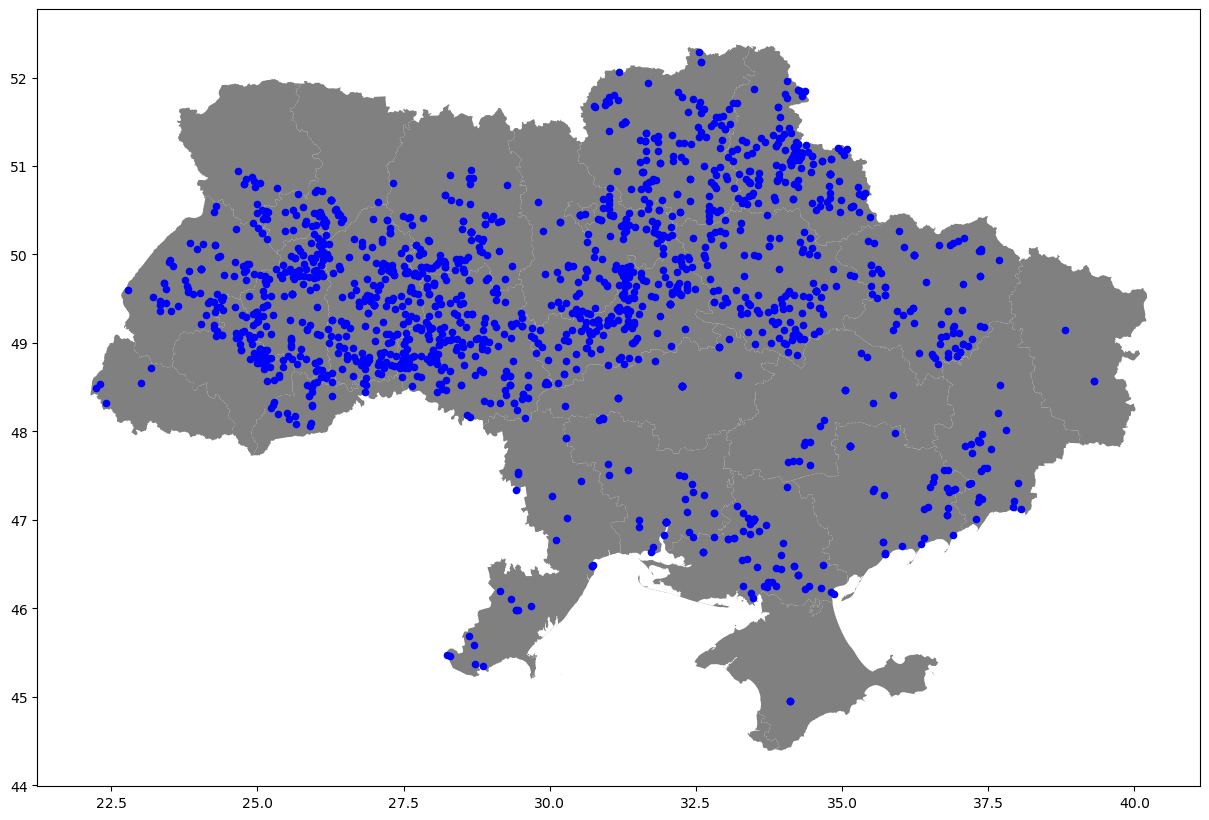

In [215]:
# Map land holdings for all companies in Ukraine
ukr_regions = gpd.read_file('../data/ukraine regional data/UKR_adm1.shp')

# Remove NAs first from "Point" column
locations_c = locations.copy()
locations_c = locations_c.dropna(subset = ["Point"])

# Create new column with point list split by comma
locations_c.loc[:, "point_lst"] = locations_c.loc[:, "Point"].str.split(",")

# Filter Ukrainian lands
deals_c = deals.copy()
deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains("ukraine", na=False), ["Deal ID"]]
final = locations_c.merge(deals_c, on="Deal ID")

# Define coordinate reference system standard
crs = {'init':'epsg:4326'}

# Create list of Point objects  
geometry = []

for coordinate in final.loc[:, "point_lst"]:
    latitude, longitude = coordinate
    geometry.append(Point(float(longitude), float(latitude)))

lands = gpd.GeoDataFrame(final, crs = crs, geometry = geometry)

# PENDING: Add region names and map title later
fig, ax = plt.subplots(figsize=(15,15))
ukr_regions.plot(ax=ax, color='grey')
lands.plot(ax=ax, markersize=20, color="blue", marker="o")
